<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/Experiments/Chapter3/3_5_NNNGP_Correlations_in_ReLU_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import quad
from tqdm import tqdm

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

In [ ]:
X_ReLU = np.array([[0.2], [0.4], [0.6], [0.8], [1.0], [1.2]])

### Find all distinct combination of $G^{(n)}$

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [ ]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### $\Delta_{1234y}$

In [ ]:
def integrand4(t, x1, x2, x3, x4, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t)

### $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
def compute_integral4(X, comb, K, Lambda, integrand=integrand4):
    res = []
    for c in comb:
        x1, x2, x3, x4 = X[c]
        res.append(quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, K))[0])
    return dict(zip([tuple(c) for c in comb], res))

### $\Delta_{1234,y,56}$

In [ ]:
def integrand6(t, x1, x2, x3, x4, x5, x6, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t) * K(x5, x6)

### $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
def compute_integral6(X, comb, K, Lambda, integrand=integrand6):
    res = []
    wick_pairs24 = [[1, 2, 3, 4, 5, 6], [1, 3, 2, 4, 5, 6], [1, 4, 2, 3, 5, 6], [1, 5, 2, 3, 4, 6], [1, 6, 2, 3, 4, 5], 
                    [2, 3, 1, 4, 5, 6], [2, 4, 1, 3, 5, 6], [2, 5, 1, 3, 4, 6], [2, 6, 1, 3, 4, 5], [3, 4, 1, 2, 5, 6], 
                    [3, 5, 1, 2, 4, 6], [3, 6, 1, 2, 4, 5], [4, 5, 1, 2, 3, 6], [4, 6, 1, 2, 3, 5], [5, 6, 1, 2, 3, 4]]
    for c in comb:
        inte = 0
        for idx in wick_pairs24:
            idx = [i-1 for i in idx]
            x1, x2, x3, x4 = X[c][idx[2:]]
            x5, x6 = X[c][idx[:2]]
            inte += quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, x5, x6, K))[0]
        res.append(inte)
    return dict(zip([tuple(c) for c in comb], res))

## ReLU-net

### ReLU-net $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [ ]:
def K_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    return sigmab2 + 0.5 * x * y

In [ ]:
def Kw_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    return 0.5 * x * y

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
%%time
integral4_ReLU = compute_integral4(X_ReLU.reshape(-1), comb4, Kw_ReLU, 100000)

CPU times: user 7.47 ms, sys: 0 ns, total: 7.47 ms
Wall time: 10.3 ms


### Compute $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
%%time
integral6_ReLU = compute_integral6(X_ReLU.reshape(-1), comb6, Kw_ReLU, 100000)

CPU times: user 494 ms, sys: 16.7 ms, total: 510 ms
Wall time: 524 ms


### Compute $K_W(x_i, x_j)$ and save the results

In [ ]:
def compute_K(X, comb, K):
    K_values = []
    for c in comb:
        x1, x2 = X[c]
        K_values.append(K(x1, x2))
    return dict(zip([tuple(c) for c in comb], K_values))

In [ ]:
K_values = compute_K(X_ReLU.reshape(-1), comb2, K_ReLU)

In [ ]:
K_values

{(0, 0): 0.020000000000000004,
 (0, 1): 0.04000000000000001,
 (0, 2): 0.06,
 (0, 3): 0.08000000000000002,
 (0, 4): 0.1,
 (0, 5): 0.12,
 (1, 1): 0.08000000000000002,
 (1, 2): 0.12,
 (1, 3): 0.16000000000000003,
 (1, 4): 0.2,
 (1, 5): 0.24,
 (2, 2): 0.18,
 (2, 3): 0.24,
 (2, 4): 0.3,
 (2, 5): 0.36,
 (3, 3): 0.32000000000000006,
 (3, 4): 0.4,
 (3, 5): 0.48,
 (4, 4): 0.5,
 (4, 5): 0.6,
 (5, 5): 0.72}

### Wick contraction

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Compute $G_{GP}^{(6)}$

In [ ]:
G_gp6_ReLU = []
for c in comb6:
    G_gp6_ReLU.append(G_gp6(X_ReLU.reshape(-1)[c], K_ReLU))
G_gp6_ReLU = dict(zip([tuple(c) for c in comb6], G_gp6_ReLU))

### Load experimental $G^{(4)}$ and $G^{(6)}$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/ReLU/'
files = list(pathlib.Path(dir).glob('*'))
lambdam4_ReLU = []
lambdam6_ReLU = []
G4_ReLU = []
G6_ReLU = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral4_ReLU[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam4_ReLU.append((A - G4) / B)
            G4_ReLU.append(G4)
        for c in comb6: 
            A = G_gp6_ReLU[tuple(c)]
            B = 24 * integral6_ReLU[tuple(c)]
            G6 = fx_exp[:, c].prod(1).mean()
            lambdam6_ReLU.append((A - G6) / B)
            G6_ReLU.append(G6)

100%|██████████| 10/10 [36:23<00:00, 218.35s/it]


### Plot $\lambda_{m4}$ 

In [ ]:
lambdam4_ReLU_df = pd.DataFrame(np.log10(np.abs(lambdam4_ReLU).reshape(10, -1)))
lambdam4_ReLU_df.index = np.log10(Ns)

In [ ]:
lambdam4_ReLU_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0.301030,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,...,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040,-24.507040
0.477121,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,...,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992,-24.679992
0.602060,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,...,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914,-24.807914
0.698970,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,...,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511,-24.902511
1.000000,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.209708,-25.

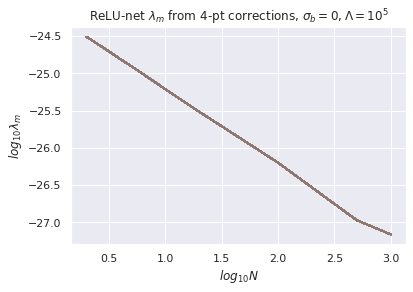

In [ ]:
ax = lambdam4_ReLU_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("ReLU-net $\lambda_m$ from 4-pt corrections, $\sigma_b=0, \Lambda=10^5$")
plt.show()

### Plot $\lambda_{m6}$ 

In [ ]:
lambdam6_ReLU_df = pd.DataFrame(np.log10(np.abs(lambdam6_ReLU).reshape(10, -1)))
lambdam6_ReLU_df.index = np.log10(Ns)

In [ ]:
lambdam6_ReLU_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461
0.301030,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,...,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728,-24.114728
0.477121,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,...,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337,-24.382337
0.602060,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,...,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047,-24.571047
0.698970,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,...,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040,-24.704040
1.000000,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-25.103393,-

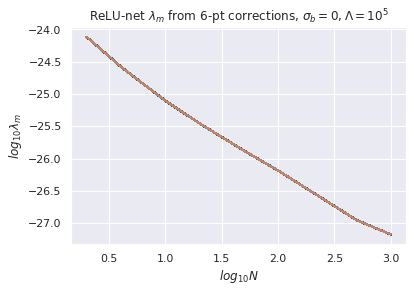

In [ ]:
ax = lambdam6_ReLU_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("ReLU-net $\lambda_m$ from 6-pt corrections, $\sigma_b=0, \Lambda=10^5$")
plt.show()

### 6-pt Deviation 

In [ ]:
N = 20

In [ ]:
file = pathlib.Path('/gdrive/MyDrive/NNGP/ReLU/fx_exp_' + str(N) + '.pickle')
lambdam4_ReLU_dev = []
lambdam6_ReLU_dev = []
G4_ReLU_dev = []
G6_ReLU_dev = []
Lambda_list = [10, 40, 80, 100, 400, 800, 1000, 4000, 8000, 10000, 40000, 80000, 100000]
for Lambda in tqdm(Lambda_list):
    integral4_ReLU = compute_integral4(X_ReLU.reshape(-1), comb4, Kw_ReLU, Lambda)
    integral6_ReLU = compute_integral6(X_ReLU.reshape(-1), comb6, Kw_ReLU, Lambda)

    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            G4 = fx_exp[:, c].prod(1).mean()
            B = 24 * integral4_ReLU[tuple(c)]
            lambdam4_ReLU_dev.append((A - G4) / B)
            G4_ReLU_dev.append(G4)
        for c in comb6: 
            A = G_gp6_ReLU[tuple(c)]
            B = 24 * integral6_ReLU[tuple(c)]
            G6 = fx_exp[:, c].prod(1).mean()
            lambdam6_ReLU_dev.append((A - G6) / B)
            G6_ReLU_dev.append(G6)




  0%|          | 0/13 [00:00<?, ?it/s]


  8%|▊         | 1/13 [03:37<43:26, 217.22s/it]


 15%|█▌        | 2/13 [07:15<39:51, 217.41s/it]


 23%|██▎       | 3/13 [10:51<36:11, 217.11s/it]


 31%|███       | 4/13 [14:28<32:33, 217.00s/it]


 38%|███▊      | 5/13 [18:04<28:55, 216.91s/it]


 46%|████▌     | 6/13 [21:41<25:17, 216.72s/it]


 54%|█████▍    | 7/13 [25:17<21:39, 216.63s/it]


 62%|██████▏   | 8/13 [28:54<18:03, 216.63s/it]


 69%|██████▉   | 9/13 [32:31<14:26, 216.71s/it]


 77%|███████▋  | 10/13 [36:07<10:49, 216.55s/it]


 85%|████████▍ | 11/13 [39:41<07:11, 215.77s/it]


 92%|█████████▏| 12/13 [43:16<03:35, 215.57s/it]


100%|██████████| 13/13 [46:49<00:00, 216.15s/it]


Prediction of GP 6-pt function and GP + $\bar{\lambda}$ correction of 6-pt function. Normalized by experimental $G^{(n)}$ function.

In [ ]:
GP_pred = np.array(list(G_gp6_ReLU.values())) / np.array(G6_ReLU_dev).reshape(13, -1)

In [ ]:
GP_lambda_pred_list = []
for i, Lambda in enumerate(Lambda_list):
    integral6_ReLU = compute_integral6(X_ReLU.reshape(-1), comb6, Kw_ReLU, Lambda)
    GP_lambda_pred = (np.array(list(G_gp6_ReLU.values())) - 24 * np.array(lambdam4_ReLU_dev).reshape(13, -1).mean(1)[i] * np.array(list(integral6_ReLU.values()))) / np.array(G6_ReLU_dev).reshape(13, -1)[i, :]
    GP_lambda_pred_list.append(GP_lambda_pred)

In [ ]:
GP_pred_df = pd.DataFrame(GP_pred, columns=[r"$G^{(6)}_{GP}$/$G^{(6)}$"]*GP_pred.shape[-1])
GP_lambda_pred_df = pd.DataFrame(np.array(GP_lambda_pred_list), 
                        columns=[r"($G^{(6)}_{GP} + \bar{\lambda}$ contribution)/$G^{(6)}$"]*GP_lambda_pred.shape[-1])

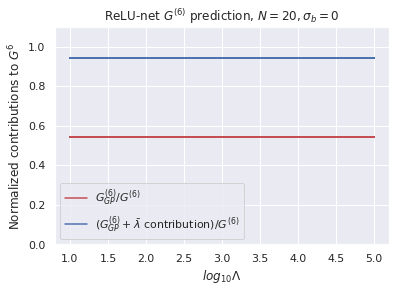

In [ ]:
colors = ['r']*GP_pred.shape[-1] + ['b']*GP_pred.shape[-1]
concated_df = pd.concat([GP_pred_df, GP_lambda_pred_df], axis=1)
concated_df.index = np.log10(Lambda_list)
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
ax.set_ylim([0.0, 1.1])
plt.xlabel("$log_{10}\Lambda$")
plt.ylabel("Normalized contributions to $G^6$")
plt.title("ReLU-net $G^{(6)}$ prediction, $N=20, \sigma_b=0$")
plt.show()